In [ ]:
import data
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from models.test_model import MambaModel
from utils.lightning import LightningMamba
from experiments.sc09_class import get_config
from torch.optim.lr_scheduler import LambdaLR
from utils.utils import set_seed, model_summary, format_time, handle_wandb_login
import wandb
import time

config = get_config()

/media/data/tmpoulionis/miniconda3/envs/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
start_time = time.time()
# Set seed for reproducibility
if config["seed"]:
    set_seed(config["seed"])

# Parse config
MODEL_CONFIG = config["model"]
TRAINER_CONFIG = config["trainer"]
DATASET_CONFIG = config["dataset"]
OPTIMIZER_CONFIG = config["optimizer"]
WANDB_CONFIG = config["wandb"]


In [3]:
# ------- Load Dataset and create DataLoaders -------
data = data.get_dataloaders(**DATASET_CONFIG)
train_loader = data["train_loader"]
val_loader = data["val_loader"]
test_loader = data["test_loader"]
num_classes = data["num_classes"]
if TRAINER_CONFIG["max_epochs"] is not None:
    total_steps = len(train_loader) * TRAINER_CONFIG["max_epochs"]
    if TRAINER_CONFIG["max_steps"] is not None:
        total_steps = min(total_steps, TRAINER_CONFIG["max_steps"])
else:
    try:
        total_steps = TRAINER_CONFIG["max_steps"]
    except: 
        raise ValueError("Either max_steps or max_epochs must be defined.")
    
print(f"  ✓ Dataset: {DATASET_CONFIG['dataset_name']}")
print(f"  ✓ Classes: {data['num_classes']}")
print(f"  ✓ Input shape: {data['input_shape']}")
print(f"  ✓ Features: {data['feature_dim']}")
print(f"  ✓ Sequence Length: {data['sequence_length']}")
    

	 Loading sc09 dataset...
	 Creating DataLoaders...
	 Dataloaders created.
  ✓ Dataset: sc09
  ✓ Classes: 10
  ✓ Input shape: torch.Size([128, 107, 64])
  ✓ Features: 64
  ✓ Sequence Length: 107


In [4]:
# ------- Create Model -------
print("Constructing Model...")
model = MambaModel(**MODEL_CONFIG, d_out=num_classes).cuda()
model_summary(model)

Constructing Model...


Layer (type:depth-idx)                   Param #
MambaModel                               --
├─ModuleList: 1-1                        --
│    └─PhotonicMamba: 2-1                --
│    │    └─Mamba: 3-1                   32,640
├─ModuleList: 1-2                        --
│    └─LayerNorm: 2-2                    128
├─LayerNorm: 1-3                         128
├─Sequential: 1-4                        --
│    └─Linear: 2-3                       8,320
│    └─LayerNorm: 2-4                    256
│    └─GELU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       1,290
Total params: 42,762
Trainable params: 42,762
Non-trainable params: 0

In [5]:
# ------- W&B Logger -------
print("\n[3/6] Setting up W&B Logger...")
usrname = handle_wandb_login()
wandb_logger = WandbLogger(
    project=WANDB_CONFIG["project"],
    entity=usrname,
    name=WANDB_CONFIG["name"],
    log_model="all",
    save_dir="./wandb_logs"
)

print(f"  ✓ Project:", wandb_logger.experiment.project)
print(f"  ✓ Name:", wandb_logger.experiment.name)
print(f"  ✓ URL:", wandb_logger.experiment.url)


[3/6] Setting up W&B Logger...

--- Weights & Biases (W&B) Configuration ---
W&B username: tmpoulionis-


wandb: Currently logged in as: tmpoulionis (tmpoulionis-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B login successful!


  ✓ Project: lightning_logs
  ✓ Name: splendid-silence-44
  ✓ URL: https://wandb.ai/tmpoulionis-/lightning_logs/runs/n7xq75va


In [7]:
# ------- Callbacks -------
print("\n[4/6] Setting up Callbacks...")

callbacks = [
    LearningRateMonitor(logging_interval='step'),
    ModelCheckpoint(
        dirpath=f"./checkpoints/{wandb_logger.name}",
        filename="best-{epoch:02d}-{val/acc:.4f}",
        monitor="val/acc",
        mode="max",
        save_top_k=1,
        save_last=True
    ),
    EarlyStopping(
        monitor="val/loss",
        patience=20,
        mode="min",
        verbose=True
    )
]

print(f"  ✓ Learning rate monitor")
print(f"  ✓ Model checkpointing (save top 3)")
print(f"  ✓ Early stopping (patience=20)")
    


[4/6] Setting up Callbacks...
  ✓ Learning rate monitor
  ✓ Model checkpointing (save top 3)
  ✓ Early stopping (patience=20)


In [8]:
# ------- Scheduler -------
from train import create_scheduler
warmup_steps = int(0.1 * total_steps)

scheduler_config = {
    "scheduler": create_scheduler,
    "params": {
        "total_steps": total_steps,
        "warmup_steps": warmup_steps
    }
}
    

In [9]:
# ------- Lightning Module -------
print("\n[5/6) Setting up Lightning Module...")
loss_fn = torch.nn.CrossEntropyLoss()

lightning_module = LightningMamba(
    model=model,
    optimizer=torch.optim.AdamW,
    loss_fn=loss_fn,
    opt_hyperparams=OPTIMIZER_CONFIG,
    scheduler_config=scheduler_config
)


[5/6) Setting up Lightning Module...


In [10]:
# ------- Trainer -------
print("\n[6/6] Initializing Trainer...")
trainer = L.Trainer(
    **TRAINER_CONFIG,
    logger=wandb_logger,
    callbacks=callbacks,
)

print(f"  ✓ Max steps: {TRAINER_CONFIG['max_steps'] if TRAINER_CONFIG['max_steps'] else 'N/A'}")
print(f"  ✓ Max epochs: {TRAINER_CONFIG['max_epochs'] if TRAINER_CONFIG['max_epochs'] else 'N/A'}")
print(f"  ✓ Accelerator: {TRAINER_CONFIG['accelerator']}")
print(f"  ✓ Gradient clip: {TRAINER_CONFIG['gradient_clip_val']}")
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



[6/6] Initializing Trainer...
  ✓ Max steps: 200000
  ✓ Max epochs: 30
  ✓ Accelerator: auto
  ✓ Gradient clip: 0.1


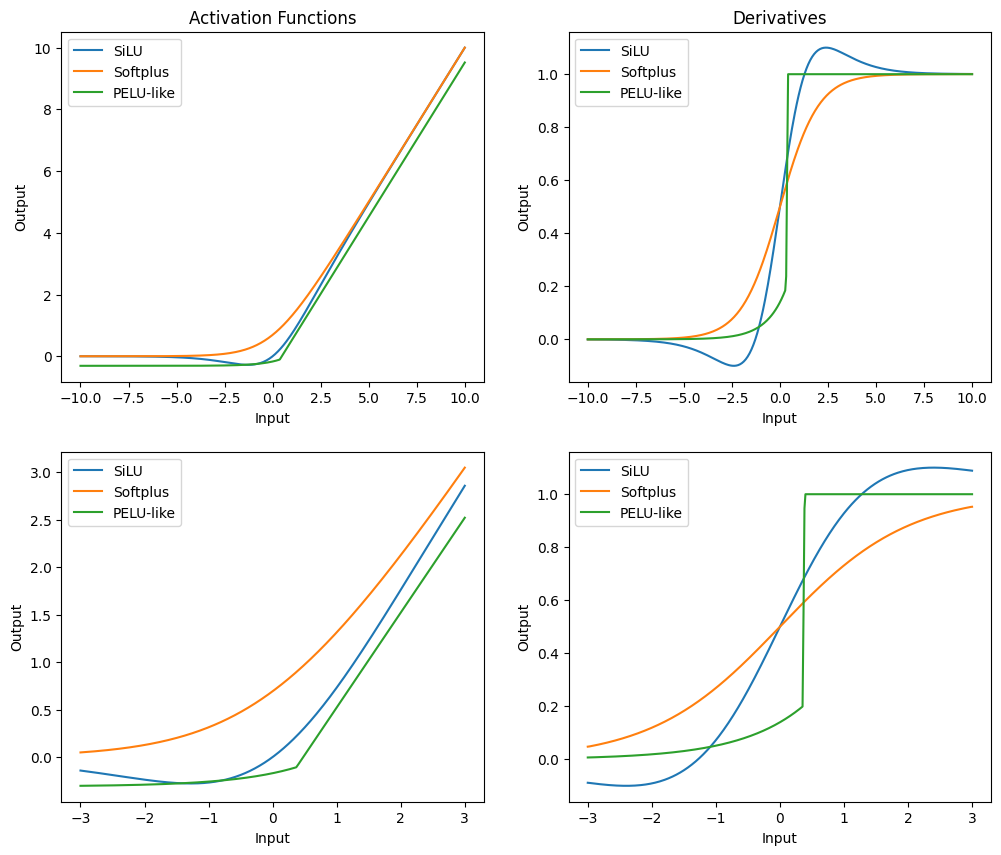

Gradient Comparison at Different x Values
       x |       SiLU |   Softplus |   PELULike
--------------------------------------------------
    -5.0 |    -0.0268 |     0.0068 |     0.0010
    -2.0 |    -0.0897 |     0.1214 |     0.0193
    -1.0 |     0.0794 |     0.2734 |     0.0526
     0.0 |     0.4875 |     0.4937 |     0.1363
     0.5 |     0.7293 |     0.6168 |     0.9996
     1.0 |     0.9206 |     0.7266 |     0.9996
     2.0 |     1.0897 |     0.8786 |     0.9996
     5.0 |     1.0268 |     0.9932 |     0.9996
    10.0 |     1.0004 |     1.0000 |     0.9996


Output Values at Different x Values
       x |       SiLU |   Softplus |   PELULike
--------------------------------------------------
    -5.0 |    -0.0335 |     0.0067 |    -0.3091
    -2.0 |    -0.2384 |     0.1269 |    -0.2911
    -1.0 |    -0.2689 |     0.3133 |    -0.2586
     0.0 |     0.0000 |     0.6931 |    -0.1703
     0.5 |     0.3112 |     0.9741 |     0.0219
     1.0 |     0.7311 |     1.3133 |     0.5217
  

In [2]:
from utils.activations import Activation
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

silu = Activation("silu")
softplus = Activation("softplus")
pelulike = Activation("pelulike")

x = torch.Tensor(np.linspace(-10, 10, 400))
dx = x[1]-x[0]

z = torch.Tensor(np.linspace(-3, 3, 400))
dz = z[1]-z[0]

grad_silu = np.gradient(silu(x).numpy(), dx.item())
grad_softplus = np.gradient(softplus(x).numpy(), dx.item())
grad_pelulike = np.gradient(pelulike(x).numpy(), dx.item())

grad_silu_z = np.gradient(silu(z).numpy(), dz.item())
grad_softplus_z = np.gradient(softplus(z).numpy(), dz.item())
grad_pelulike_z = np.gradient(pelulike(z).numpy(), dz.item())

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0,0].plot(x, silu(x), label="SiLU")
ax[0,0].plot(x, softplus(x), label="Softplus")
ax[0,0].plot(x, pelulike(x), label="PELU-like")
ax[0,0].set_title("Activation Functions")
ax[0,0].set_xlabel("Input")
ax[0,0].set_ylabel("Output")
ax[0,0].legend()

ax[0,1].plot(x, grad_silu, label="SiLU")
ax[0,1].plot(x, grad_softplus, label="Softplus")
ax[0,1].plot(x, grad_pelulike, label="PELU-like")
ax[0,1].set_title("Derivatives")
ax[0,1].set_xlabel("Input")
ax[0,1].set_ylabel("Output")
ax[0,1].legend()

ax[1,0].plot(z, silu(z), label="SiLU")
ax[1,0].plot(z, softplus(z), label="Softplus")
ax[1,0].plot(z, pelulike(z), label="PELU-like")
ax[1,0].set_xlabel("Input")
ax[1,0].set_ylabel("Output")
ax[1,0].legend()

ax[1,1].plot(z, grad_silu_z, label="SiLU")
ax[1,1].plot(z, grad_softplus_z, label="Softplus")
ax[1,1].plot(z, grad_pelulike_z, label="PELU-like")
ax[1,1].set_xlabel("Input")
ax[1,1].set_ylabel("Output")
ax[1,1].legend()
plt.show()

print("Gradient Comparison at Different x Values")
print(f"{'x':>8} | {'SiLU':>10} | {'Softplus':>10} | {'PELULike':>10}")
print("-" * 50)

test_points = [-5, -2, -1, 0, 0.5, 1, 2, 5, 10]
for xp in test_points:
    idx = np.argmin(np.abs(x.numpy() - xp))
    print(f"{xp:>8.1f} | {grad_silu[idx]:>10.4f} | {grad_softplus[idx]:>10.4f} | {grad_pelulike[idx]:>10.4f}")

print("\n")
print("Output Values at Different x Values")
print(f"{'x':>8} | {'SiLU':>10} | {'Softplus':>10} | {'PELULike':>10}")
print("-" * 50)

for xp in test_points:
    x_tensor = torch.tensor([xp], dtype=torch.float32)
    s = silu(x_tensor).item()
    sp = softplus(x_tensor).item()
    p = pelulike(x_tensor).item()
    print(f"{xp:>8.1f} | {s:>10.4f} | {sp:>10.4f} | {p:>10.4f}")

